In [136]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Dec  14 19:17:35 2017

@author: fushen
"""
import numpy as np 
import scipy
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator,ClassifierMixin





In [137]:

def plotFigureAllInOne(GD,NAG,Adadelta,RMSprop,Adam,X,Y,tuned='tuned',every=20,size=6,path=None):
    GD_loss_test = GD.getLossHistory(X,Y)
    NAG_loss_test = NAG.getLossHistory(X,Y)
    Adadelta_loss_test = Adadelta.getLossHistory(X,Y)
    RMSprop_loss_test = RMSprop.getLossHistory(X,Y)
    Adam_loss_test = Adam.getLossHistory(X,Y)
    
    _, ax = plt.subplots()
    ax.plot(range(len(GD_loss_test)),GD_loss_test,'.-',markersize=size,markevery=every,label=\
            r'GD,$\lambda$=%.2f,$\eta$=%.2f'\
            %(GD.get_params()['lamda'],GD.get_params()['eta']))
    ax.plot(range(len(NAG_loss_test)),NAG_loss_test,'s-',markersize=size,markevery=every,label=\
            r'NAG,$\lambda$=%.2f,$\eta$=%.2f,$\gamma$=%.2f'\
            %(NAG.get_params()['lamda'],NAG.get_params()['eta'],NAG.get_params()['gamma']))
    ax.plot(range(len(Adadelta_loss_test)),Adadelta_loss_test,'*-',markersize=size,markevery=every,label=\
            r'Adadelta,$\lambda$=%.2f,$\gamma$=%.2f'\
            %(Adadelta.get_params()['lamda'],Adadelta.get_params()['gamma']))
    ax.plot(range(len(RMSprop_loss_test)),RMSprop_loss_test,'v-',markersize=size,markevery=every,label=\
            r'RMSprop,$\lambda$=%.2f,$\eta$=%.2f,$\gamma$=%.2f'\
            %(RMSprop.get_params()['lamda'],RMSprop.get_params()['eta'],RMSprop.get_params()['gamma']))
    ax.plot(range(len(Adam_loss_test)),Adam_loss_test,'d-',markersize=size,markevery=every,label=\
            r'Adam,$\lambda$=%.2f,$\eta$=%.2f,$\beta_1$=%.2f,$\beta_2$=%.3f'\
            %(Adam.get_params()['lamda'],Adam.get_params()['eta'],Adam.get_params()['Adam_beta1'],Adam.get_params()['Adam_beta2']))
    
    plt.legend()
    plt.title('Different %s estimators\' performance'%tuned)
    ax.set(xlabel='Epoch', ylabel='Loss in testset with l2 norm')
    
    if path!=None:
        plt.savefig(path,format='pdf')
    
    plt.show()
    plt.close('all')
    
def plotFigureTrainTest(cls,X_train,Y_train,X_test,Y_test,every=20,size=6,path=None):
    loss_train = cls.getLossHistory(X_train,Y_train)
    loss_test = cls.getLossHistory(X_test,Y_test)
    accuracy_train = cls.getScoreHistory(X_train,Y_train)
    accuracy_test = cls.getScoreHistory(X_test,Y_test)
    
    _, ax = plt.subplots()
    ax_e = ax.twinx()
    ax.plot(range(len(loss_train)),loss_train,'*-b',markersize=size,markevery=every,label='train loss')
    ax.plot(range(len(loss_test)),loss_test,'v-g',markersize=size,markevery=every,label='test loss')
    ax_e.plot(range(len(accuracy_train)),accuracy_train,'*-r',markersize=size,markevery=every,label='train accuracy')
    ax_e.plot(range(len(accuracy_test)),accuracy_test,'v-m',markersize=size,markevery=every,label='test accuracy')
        
    ax.set(xlabel='Epoch', ylabel='Loss with l2 norm')
    ax_e.set_ylabel('Accuracy with threshold=%s'%str(cls.get_params()['threshold']))
    
    ax.legend(loc=4)
    ax_e.legend(loc=1)
    
    if path!=None:
        plt.savefig(path,format='pdf')
        
    plt.show()
    plt.close('all')

In [138]:
class op():
    def gradient_decent(w,gradient,eta):
        return w - eta * gradient

    def NAG(w,gradient,last_delta,eta,gamma):
        delta = gamma * last_delta + eta * gradient
        return w-delta,delta

    def Adadelta(w,gradient,last_E_g_2,last_E_delta_2,gamma):
        E_g_2 = gamma * last_E_g_2 + (1-gamma) * (gradient*gradient)
        RMS_g = np.sqrt(E_g_2+epsilon)
        RMS_last_delta = np.sqrt(last_E_delta_2+epsilon)
        delta = RMS_last_delta / RMS_g * gradient
        return w - delta,\
                E_g_2,\
                gamma * last_E_delta_2 + (1-gamma) * (delta*delta)

    def RMSprop(w,gradient,last_E_g_2,eta,gamma):
        E_g_2 = gamma * last_E_g_2 + (1-gamma) * (gradient*gradient)
        return w - (eta/np.sqrt(E_g_2+epsilon))*gradient,\
                E_g_2
            
    def Adam(w,gradient,last_m,last_v,eta,beta1,beta2,epoch,counteract_bias=True):
        m = beta1 * last_m + (1-beta1) * gradient
        v = beta2 * last_v + (1-beta2) * (gradient*gradient)
        if counteract_bias:
            m = m/(1-beta1**epoch)
            v = v/(1-beta2**epoch)
        
        return w - (eta/(np.sqrt(v)+epsilon))*m,\
            m*(1-beta1**epoch),v*(1-beta2**epoch)



In [139]:
class Classifier(BaseEstimator,ClassifierMixin):  
    """A Logistic regression Classifier for ML2017-lab-02"""
    
    def __init__(self, w=0, lamda=0.1, eta=0.05, gamma=0.9,\
                 threshold=0.5, max_iterate=100, batch_size=10000,\
                 Adam_beta1=0.9, Adam_beta2=0.999,\
                 Adadelta_last_E_delta_2_init=1e-4, optimizer='GD'):
        """
        Called when initializing the classifier,
        optimizer expectes {'NAG','Adadelta','RMSprop','Adam','GD'}
        """
        self.w = w
        self.lamda = lamda
        self.eta = eta
        self.gamma = gamma
        self.threshold = threshold
        self.max_iterate = max_iterate
        self.batch_size = batch_size
        self.Adam_beta1 = Adam_beta1
        self.Adam_beta2 = Adam_beta2
        self.Adadelta_last_E_delta_2_init = Adadelta_last_E_delta_2_init
        self.optimizer = optimizer
        
        self.w_history = []
        epsilon = 1e-8




        
    def sigmoid(self,inX):  
        return 1.0 / (1 + np.exp(-inX))
    
    def __h(self,w,X):
        return self.sigmoid(X.dot(w))
    
    def h(self,X):
        return self.__h(self.w,X)
    
    def L(self,X,Y):
        return self.__L(self.w,X,Y)
    
    def __L(self,w,X,Y):
        num_records,num_features  = np.shape(X)  
        lamda = self.lamda
        
        hx = self.__h(w,X)
        regulation_loss = 1.0/2 * lamda * w.transpose().dot(w)
        loss = 1.0/2 * 1.0/(1 - -1) * 1.0/num_records * (-np.log(hx).transpose().dot(1+Y) - np.log(1-hx).transpose().dot(1-Y))\
                + regulation_loss
                
        return loss[0][0]
        
    def g(self,X,Y):
        return self.__g(self.w,X,Y)
    
    def __g(self,w,X,Y):
        num_records,num_features  = np.shape(X)    
        lamda = self.lamda
    
        # L2 norm
        return 1.0/num_records * X.transpose().dot(2*self.__h(w,X)-(Y+1)) \
                + lamda * w
            
    
    def fit(self, X, Y):
        """
        A reference implementation of a fitting function
        Parameters
        ----------
        X : array-like or sparse matrix of shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples] or [n_samples, n_outputs]
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        self.classes_, _ = np.unique(Y, return_inverse=True)
        train_size,num_features  = np.shape(X)
        batch_size = self.batch_size
        optimizer = self.optimizer
        eta = self.eta
        gamma = self.gamma
        
        NAG_last_delta = np.zeros((num_features,1))
        
        Adadelta_last_E_g_2 = np.zeros((num_features,1))
        Adadelta_last_E_delta_2 = np.zeros((num_features,1)) + self.Adadelta_last_E_delta_2_init
        
        RMSprop_last_E_g_2 = np.zeros((num_features,1))
        
        Adam_last_m = np.zeros((num_features,1))
        Adam_last_v = np.zeros((num_features,1))
        
        epoch = 0 
        self.w_history.append(self.w)
        for counter in range(self.max_iterate):
            starts = [i*batch_size for i in range(math.ceil(train_size/batch_size))]
            ends = [i*batch_size for i in range(1,math.ceil(train_size/batch_size))]
            ends.append(train_size)
            for start, end in zip(starts, ends):
                
                if optimizer == 'NAG':
                    # Nesterov accelerated gradient decent
                    self.w,NAG_last_delta =\
                        op.NAG(self.w,
                            self.g(X[start:end,:],Y[start:end,:]),
                            NAG_last_delta,eta,gamma)
                    self.w_history.append(self.w)
                elif optimizer == 'Adadelta':
                    # Adadelta gradient decent
                    self.w, Adadelta_last_E_g_2, Adadelta_last_E_delta_2 =\
                        op.Adadelta(self.w,
                                self.g(X[start:end,:],Y[start:end,:]),
                                 Adadelta_last_E_g_2,
                                 Adadelta_last_E_delta_2,
                                 gamma)       
                    self.w_history.append(self.w)             
                elif optimizer == 'RMSprop':
                    # RMSprop gradient decent
                    self.w, RMSprop_last_E_g_2 =\
                        op.RMSprop(self.w,
                                self.g(X[start:end,:],Y[start:end,:]),
                                RMSprop_last_E_g_2,
                                eta,gamma)      
                    self.w_history.append(self.w)              
                elif optimizer == 'Adam':
                    # Adaptive Moment Estimation
                    self.w, Adam_last_m, Adam_last_v =\
                        op.Adam(self.w,
                             self.g(X[start:end,:],Y[start:end,:]),
                             Adam_last_m,
                             Adam_last_v,
                             eta,self.Adam_beta1,self.Adam_beta2,epoch+1)       
                    self.w_history.append(self.w)             
                elif optimizer == 'GD':
                    # mini-batch gradient decent
                    self.w = op.gradient_decent(self.w,
                        self.g(X[start:end,:],Y[start:end,:]),
                        eta)
                    self.w_history.append(self.w)
                    
                else:
                    raise ValueError("Optimizer error, expected {'NAG','Adadelta','RMSprop','Adam','GD'}, got %s" % optimizer)
        
            epoch += 1 
        
        return self    
    
    def __predict(self,w,X):
        threshold = self.threshold
        raw = self.__h(w,X)
        raw[raw<=threshold] = self.classes_[0]
        raw[raw>threshold] = self.classes_[1]
        return raw
    
    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.
        Returns
        -------
        y : array of shape = [n_samples]
            Returns :math:`x^2` where :math:`x` is the first column of `X`.
        """
        return self.__predict(self.w,X)
    
    def __score(self,w,X,Y):
        num_records,num_features  = np.shape(X)
        P = self.__predict(w,X)
        
        is_right = P * Y
        is_right[is_right < 0] = 0
        
        return 1.0/num_records * np.count_nonzero(is_right)
    
    def score(self, X, Y):
        # RMSE
        return self.__score(self.w,X,Y)
    
    def getLossHistory(self,X,Y):
        return [self.__L(w,X,Y) for w in self.w_history]
    
    def getScoreHistory(self,X,Y):
        return [self.__score(w,X,Y) for w in self.w_history]
    

Start to figure the loss curves of       untuned estimators in one figure


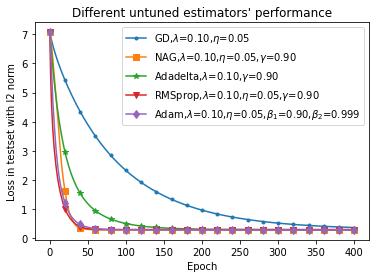

Start to execute exhaustive grid search
Exhaustive Grid Search Result of NAG
The best estimator's parameter is {'eta': 0.05, 'gamma': 0.95, 'lamda': 0.01, 'threshold': 0.5}
   rank_test_score  mean_test_score  mean_train_score  mean_fit_time  \
0                1         0.843432          0.844246       0.449702   
1                2         0.842849          0.843402       0.429284   
2                3         0.837290          0.838073       0.408598   
3                4         0.836891          0.836891       0.422125   
4                5         0.832653          0.833098       0.422889   
5                6         0.829305          0.829935       0.436629   

                                              params  
0  {'eta': 0.05, 'gamma': 0.95, 'lamda': 0.01, 't...  
1  {'eta': 0.05, 'gamma': 0.9, 'lamda': 0.01, 'th...  
2  {'eta': 0.05, 'gamma': 0.95, 'lamda': 0.01, 't...  
3  {'eta': 0.05, 'gamma': 0.9, 'lamda': 0.01, 'th...  
4  {'eta': 0.05, 'gamma': 0.8, 'lamda': 0.01, '

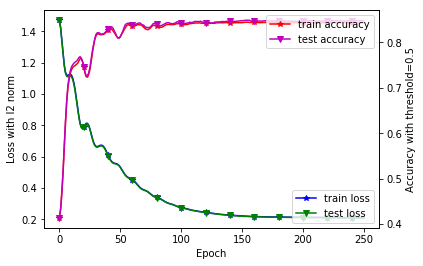

Figure of {'eta': 0.05, 'gamma': 0.95, 'lamda': 0.01, 'threshold': 0.5}


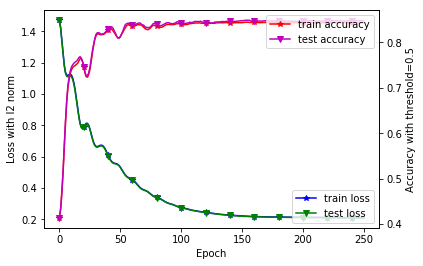

Exhaustive Grid Search Result of Adadelta
The best estimator's parameter is {'gamma': 0.95, 'lamda': 0.01, 'threshold': 0.5}
   rank_test_score  mean_test_score  mean_train_score  mean_fit_time  \
0                1         0.839655          0.840545       0.748903   
1                2         0.834956          0.835816       0.493006   
2                3         0.832499          0.833006       0.556812   
3                4         0.830073          0.829965       0.889216   
4                5         0.826019          0.826403       0.492731   
5                6         0.825159          0.826526       0.548432   

                                             params  
0  {'gamma': 0.95, 'lamda': 0.01, 'threshold': 0.5}  
1   {'gamma': 0.9, 'lamda': 0.01, 'threshold': 0.5}  
2  {'gamma': 0.95, 'lamda': 0.01, 'threshold': 0.6}  
3   {'gamma': 0.9, 'lamda': 0.01, 'threshold': 0.6}  
4   {'gamma': 0.95, 'lamda': 0.1, 'threshold': 0.5}  
5   {'gamma': 0.8, 'lamda': 0.01, 'threshold':

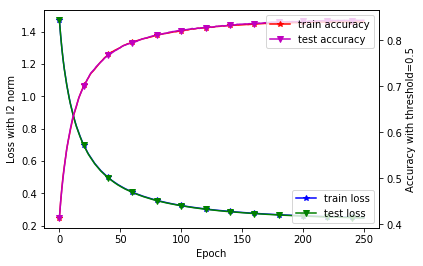

Figure of {'gamma': 0.9, 'lamda': 0.01, 'threshold': 0.5}


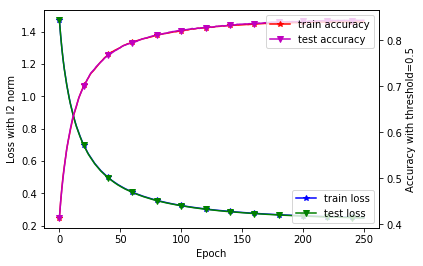

Exhaustive Grid Search Result of RMSprop
The best estimator's parameter is {'eta': 0.05, 'gamma': 0.8, 'lamda': 0.01, 'threshold': 0.6}
   rank_test_score  mean_test_score  mean_train_score  mean_fit_time  \
0                1         0.844077          0.844277       0.520238   
1                2         0.842265          0.843279       0.558665   
2                3         0.841068          0.840791       1.053417   
3                4         0.838918          0.838780       0.801530   
4                5         0.838672          0.837904       0.938846   
5                6         0.838150          0.838703       0.662849   

                                              params  
0  {'eta': 0.05, 'gamma': 0.8, 'lamda': 0.01, 'th...  
1  {'eta': 0.05, 'gamma': 0.8, 'lamda': 0.01, 'th...  
2  {'eta': 0.05, 'gamma': 0.9, 'lamda': 0.01, 'th...  
3  {'eta': 0.01, 'gamma': 0.8, 'lamda': 0.01, 'th...  
4  {'eta': 0.01, 'gamma': 0.9, 'lamda': 0.01, 'th...  
5  {'eta': 0.05, 'gamma': 0.9

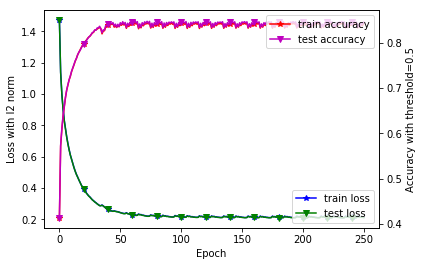

Figure of {'eta': 0.05, 'gamma': 0.9, 'lamda': 0.01, 'threshold': 0.5}


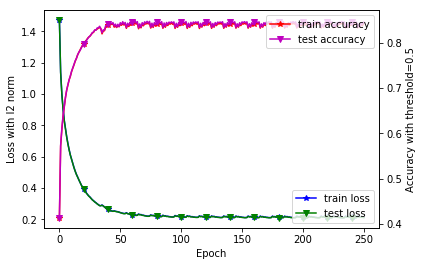

Exhaustive Grid Search Result of Adam
The best estimator's parameter is {'Adam_beta1': 0.9, 'Adam_beta2': 0.99, 'eta': 0.05, 'lamda': 0.01, 'threshold': 0.5}
   rank_test_score  mean_test_score  mean_train_score  mean_fit_time  \
0                1         0.844108          0.844139       1.080871   
1                1         0.844108          0.844108       1.104318   
2                3         0.843954          0.843739       0.464588   
3                4         0.843801          0.844630       0.786134   
4                5         0.837106          0.837321       0.738090   
5                6         0.836952          0.837290       0.979729   

                                              params  
0  {'Adam_beta1': 0.9, 'Adam_beta2': 0.99, 'eta':...  
1  {'Adam_beta1': 0.9, 'Adam_beta2': 0.999, 'eta'...  
2  {'Adam_beta1': 0.95, 'Adam_beta2': 0.99, 'eta'...  
3  {'Adam_beta1': 0.95, 'Adam_beta2': 0.999, 'eta...  
4  {'Adam_beta1': 0.95, 'Adam_beta2': 0.999, 'eta...  
5  {'Ad

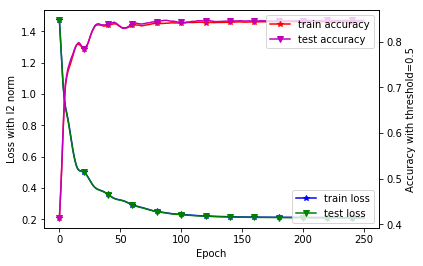

Figure of {'Adam_beta1': 0.95, 'Adam_beta2': 0.999, 'eta': 0.05, 'lamda': 0.01, 'threshold': 0.5}


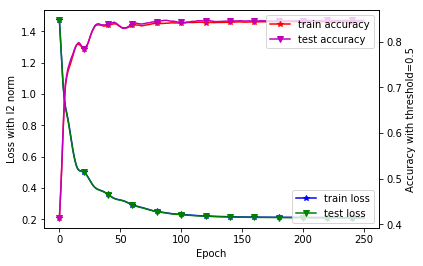

Exhaustive Grid Search Result of GD
The best estimator's parameter is {'eta': 0.5, 'lamda': 0.01, 'threshold': 0.5}
   rank_test_score  mean_test_score  mean_train_score  mean_fit_time  \
0                1         0.843002          0.842972       0.427950   
1                2         0.840177          0.841252       0.417500   
2                3         0.837597          0.838396       0.414149   
3                4         0.836891          0.836937       0.422219   
4                4         0.836891          0.836998       0.521385   
5                6         0.836307          0.836722       0.428349   

                                          params  
0  {'eta': 0.5, 'lamda': 0.01, 'threshold': 0.5}  
1  {'eta': 0.4, 'lamda': 0.01, 'threshold': 0.5}  
2  {'eta': 0.5, 'lamda': 0.01, 'threshold': 0.4}  
3  {'eta': 0.5, 'lamda': 0.01, 'threshold': 0.6}  
4  {'eta': 0.3, 'lamda': 0.01, 'threshold': 0.5}  
5  {'eta': 0.4, 'lamda': 0.01, 'threshold': 0.6}  
Result has been saved 

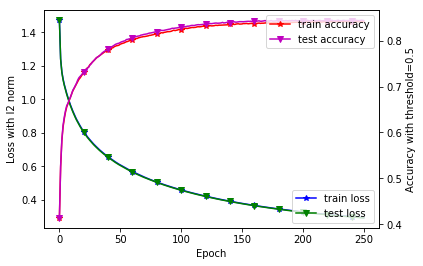

Figure of {'eta': 0.3, 'lamda': 0.01, 'threshold': 0.5}


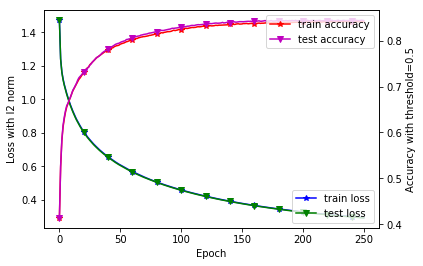

Start to figure the accuracy and loss curves of       estimators of different optimized algorithms with tuned hyperparameter
Optimizer NAG, parameters:
{'Adadelta_last_E_delta_2_init': 0.0001, 'Adam_beta1': 0.9, 'Adam_beta2': 0.999, 'batch_size': 8000, 'eta': 0.05, 'gamma': 0.95, 'lamda': 0.01, 'max_iterate': 50, 'optimizer': 'NAG', 'threshold': 0.5}


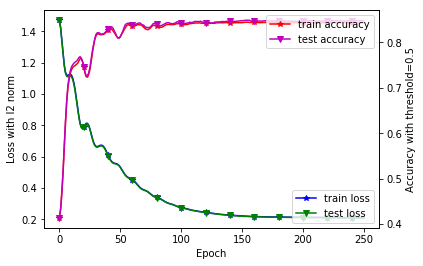

Optimizer Adadelta, parameters:
{'Adadelta_last_E_delta_2_init': 0.0001, 'Adam_beta1': 0.9, 'Adam_beta2': 0.999, 'batch_size': 8000, 'eta': 0.05, 'gamma': 0.95, 'lamda': 0.01, 'max_iterate': 50, 'optimizer': 'Adadelta', 'threshold': 0.5}


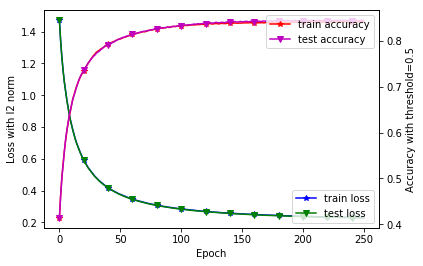

Optimizer RMSprop, parameters:
{'Adadelta_last_E_delta_2_init': 0.0001, 'Adam_beta1': 0.9, 'Adam_beta2': 0.999, 'batch_size': 8000, 'eta': 0.05, 'gamma': 0.8, 'lamda': 0.01, 'max_iterate': 50, 'optimizer': 'RMSprop', 'threshold': 0.6}


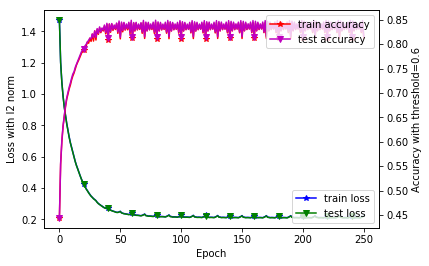

Optimizer Adam, parameters:
{'Adadelta_last_E_delta_2_init': 0.0001, 'Adam_beta1': 0.9, 'Adam_beta2': 0.99, 'batch_size': 8000, 'eta': 0.05, 'gamma': 0.9, 'lamda': 0.01, 'max_iterate': 50, 'optimizer': 'Adam', 'threshold': 0.5}


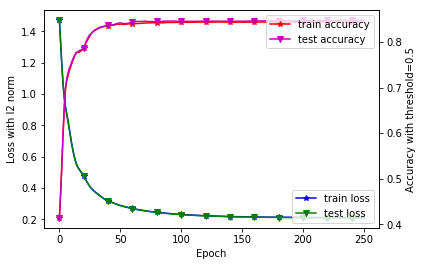

Optimizer GD, parameters:
{'Adadelta_last_E_delta_2_init': 0.0001, 'Adam_beta1': 0.9, 'Adam_beta2': 0.999, 'batch_size': 8000, 'eta': 0.5, 'gamma': 0.9, 'lamda': 0.01, 'max_iterate': 50, 'optimizer': 'GD', 'threshold': 0.5}


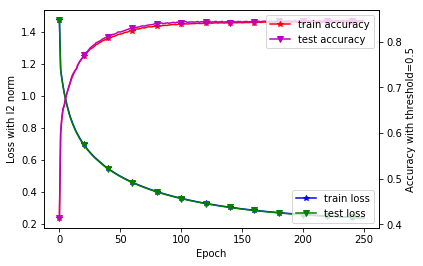

Start to figure the loss curves of       tuned estimators in one figure


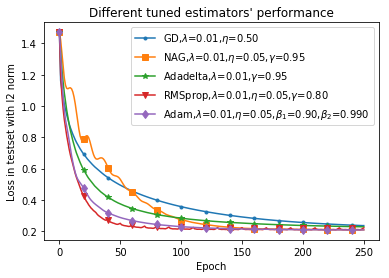

In [140]:
result_path = './results/regression/grid_search'

X_train, Y_train = load_svmlight_file("./resources/a9a")
X_test, Y_test = load_svmlight_file("./resources/a9a.t")

X_train = scipy.sparse.hstack(\
    (scipy.sparse.csr_matrix(np.ones((len(Y_train),1))),X_train))
X_test = scipy.sparse.hstack(\
    (scipy.sparse.csr_matrix(np.ones((len(Y_test),1))),X_test))
#Something wrong with this dataset
X_test = scipy.sparse.hstack(\
    (X_test, scipy.sparse.csr_matrix(np.zeros((len(Y_test),1)))))

X_train = X_train.tocsr()
X_test = X_test.tocsr()

Y_train = Y_train.reshape((len(Y_train),1))
Y_test = Y_test.reshape((len(Y_test),1))

train_size,num_features  = np.shape(X_train)

max_iterate = 50
batch_size = 8000

figure_num = 2

init_w = np.random.normal(size=(num_features,1))

optimizers = ['NAG','Adadelta','RMSprop','Adam','GD']
o = {}

param_grid = {
        'NAG': {'lamda': [0.01, 0.1], 
               'eta': [0.01, 0.05],
               'gamma': [0.8, 0.9, 0.95],
               'threshold': [0.5,0.6]},
        'Adadelta' : {'lamda': [0.01, 0.1],
                      'gamma': [0.8, 0.9, 0.95],
                      'threshold': [0.5,0.6]},
        'RMSprop' : {'lamda': [0.01, 0.1], 
                   'eta': [0.01, 0.05],
                   'gamma': [0.8, 0.9, 0.95],
                   'threshold': [0.5,0.6]},
        'Adam' : {'lamda': [0.01, 0.1], 
                   'eta': [0.01, 0.05],
                   'Adam_beta1': [0.9, 0.95],
                   'Adam_beta2' : [0.99, 0.999],
                   'threshold': [0.5,0.6]},
        'GD' : {'lamda': [0.01, 0.1, 0.5], 
               'eta': [0.1, 0.2, 0.3, 0.4, 0.5],
               'threshold': [0.4,0.5,0.6]}}
        
print ("===========================")
print ("Start to figure the loss curves of\
       untuned estimators in one figure")
init_w = np.random.normal(size=(num_features,1))
GD = Classifier(w=init_w,optimizer='GD')
NAG = Classifier(w=init_w,optimizer='NAG')
Adadelta = Classifier(w=init_w,optimizer='Adadelta')
RMSprop = Classifier(w=init_w,optimizer='RMSprop')
Adam = Classifier(w=init_w,optimizer='Adam')

GD.fit(X_train,Y_train)
NAG.fit(X_train,Y_train)
Adadelta.fit(X_train,Y_train)
RMSprop.fit(X_train,Y_train)
Adam.fit(X_train,Y_train)

plotFigureAllInOne(GD,NAG,Adadelta,RMSprop,Adam,X_test,Y_test,'untuned',path='./results/regression/LR_untuned.pdf')

every=20
size=6
print ("===========================")
print ("Start to execute exhaustive grid search")
for i in range(len(optimizers)):
    optimizer_name = optimizers[i]
    
    cls = GridSearchCV(Classifier(init_w,max_iterate=max_iterate,batch_size=batch_size,optimizer=optimizer_name), param_grid[optimizer_name],return_train_score=True,n_jobs=4)
    cls.fit(X_train,Y_train)
    result = pd.DataFrame(cls.cv_results_)
    result.sort_values('rank_test_score',inplace=True)
    result = result.reset_index(drop = True)
    
    # Best optimizer
    o[optimizer_name] = cls.best_estimator_
    
    print ("Exhaustive Grid Search Result of %s"%optimizer_name)
    print ("The best estimator's parameter is",cls.best_params_)
    print (result.loc[0:5,['rank_test_score','mean_test_score','mean_train_score','mean_fit_time','params']])
    path = result_path+'_'+optimizer_name+'.csv'
    result.to_csv(path)
    print ("Result has been saved in",path)
    
    
    print ("Printing the best %d models loss curves"%figure_num)
    for j in range(figure_num):
        params = result.loc[i,'params']
        print ("Figure of",params)
        cls = Classifier(init_w,max_iterate=max_iterate,batch_size=batch_size,optimizer=optimizer_name,**params)
        cls.fit(X_train,Y_train)
        plotFigureTrainTest(cls,X_train,Y_train,X_test,Y_test,path='./results/regression/LR_%s_%d.pdf'%(optimizer_name,j))
    
    
print ("===========================")
print ("Start to figure the accuracy and loss curves of\
       estimators of different optimized algorithms with tuned hyperparameter")
for i in range(len(optimizers)):
    cls_name = optimizers[i]
    cls = o[cls_name]
    
    print("Optimizer %s, parameters:"%cls_name)
    params = cls.get_params()
    params.pop('w')
    print(params)
    
    plotFigureTrainTest(cls,X_train,Y_train,X_test,Y_test,path='./results/regression/LR_%s.pdf'%cls_name)

print ("===========================")
print ("Start to figure the loss curves of\
       tuned estimators in one figure")

GD = o['GD']
NAG = o['NAG']
Adadelta = o['Adadelta']
RMSprop = o['RMSprop']
Adam = o['Adam']

plotFigureAllInOne(GD,NAG,Adadelta,RMSprop,Adam,X_test,Y_test,'tuned',path='./results/regression/LR_tuned.pdf')